In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import os
import tensorflow as tf
#import gym
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, InputLayer
from sklearn.model_selection import train_test_split
from finta import TA
sequence_length = 14

2024-04-02 05:21:03.905978: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-02 05:21:05.062606: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Descargar los precios
tickers_with_dates = [
    ("AAPL", "2010-01-01", "2023-12-31"),
    ("MSFT", "2010-01-01", "2023-12-31"),
    ("AMZN", "2010-01-01", "2023-12-31"),
    ("GOOG", "2010-01-01", "2023-12-31"),
    ("TSLA", "2010-01-01", "2023-12-31"),
    ("META", "2010-01-01", "2023-12-31"),
    ("JNJ", "2010-01-01", "2023-12-31"),
    ("BAC", "2010-01-01", "2023-12-31"),
    ("JPM", "2010-01-01", "2023-12-31"),
    ("NVDA", "2010-01-01", "2023-12-31"),
    ("TSM", "2010-01-01", "2023-12-31"),
    ("BABA", "2010-01-01", "2023-12-31"),
    ("ADBE", "2010-01-01", "2023-12-31"),
    ("CRM", "2010-01-01", "2023-12-31"),
    ("WMT", "2010-01-01", "2023-12-31"),
    ("DIS", "2010-01-01", "2023-12-31"),
    ("KO", "2010-01-01", "2023-12-31"),
    ("PG", "2010-01-01", "2023-12-31"),
    ("VZ", "2010-01-01", "2023-12-31"),
    ("XOM", "2010-01-01", "2023-12-31"),
    ("CVX", "2010-01-01", "2023-12-31"),
    ("INTC", "2010-01-01", "2023-12-31"),
    ("PFE", "2010-01-01", "2023-12-31"),
    ("UNH", "2010-01-01", "2023-12-31"),
    ("COST", "2010-01-01", "2023-12-31"),
    ("HD", "2010-01-01", "2023-12-31"),
    ("MCD", "2010-01-01", "2023-12-31"),
    ("PEP", "2010-01-01", "2023-12-31"),
    ("MA", "2010-01-01", "2023-12-31")
]

datas = {}
for i in tickers_with_dates:

    try:
        # Attempt to download data for the ticker
        datas[i[0]] = yf.download(i[0], start=i[1], end=i[2], interval="1d")
    except yf.TickerNotFound:
        print(f"{i[0]}: Ticker not found")
    
    

# data = yf.download('AAPL', start='2005-9-29', end='2024-01-01', interval="1d")
# Imprimir data
#print(data.head())

# Obtener los precios de cierre y las fechas
# prices = data['Adj Close'].values
# dates = data.index.to_numpy()
# prices

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [3]:
# Función para calcular el RSI
def calculate_rsi(prices, n=30):
    deltas = np.diff(prices)
    seed = deltas[:n + 1]
    up = seed[seed >= 0].sum() / n
    down = -seed[seed < 0].sum() / n
    rs = up / down
    rsi = [np.nan] * (n - 1) + [100. - 100. / (1. + rs)]

    for i in range(n, len(prices)):
        delta = deltas[i - 1]  # Cambio actual
        if delta > 0:
            upval = delta
            downval = 0.
        else:
            upval = 0.
            downval = -delta
        up = (up * (n - 1) + upval) / n
        down = (down * (n - 1) + downval) / n
        rs = up / down
        rsi.append(100. - 100. / (1. + rs))

    return rsi

# Calcular el RSI
# rsi = calculate_rsi(prices,sequence_length)
#calcular Rsi de cada ticker
rsis={}
for k,v in datas.items():
    rsis[k] = calculate_rsi(v['Adj Close'].values, sequence_length)
    # prices = i['Adj Close'].values
    # dates = i.index.to_numpy()
    # rsis[k] = ()
rsis['AAPL']

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 42.2507389399789,
 47.97506122142716,
 50.807901775971345,
 52.68351966654949,
 44.57875629298919,
 39.12333182637979,
 41.948623807281685,
 43.151201403609505,
 46.69740139070392,
 40.85057008641491,
 44.410437123715575,
 43.30738608697947,
 45.55698051716662,
 44.57241183626143,
 48.54550365419888,
 50.39019998560662,
 53.55691153379016,
 52.54035238943784,
 52.970124253265226,
 51.31095737056513,
 49.64934387651149,
 45.39426443933115,
 50.30825233787098,
 52.038447260459215,
 55.314309896151805,
 60.197633846019166,
 59.971601963669016,
 60.51921241475247,
 62.12335277719121,
 69.96966455129487,
 70.07497433126711,
 73.14876738656716,
 74.45406662464129,
 74.93001125262641,
 75.74126925083362,
 69.65114081433966,
 70.22106883422806,
 69.46117751832408,
 70.02226012296215,
 64.26423371737144,
 67.28235413987201,
 71.08057225781424,
 72.0579279567882,
 65.6255128696145,
 70.11469100123558,
 71.518905833832

## TODO: Revisar

In [4]:
TA.RSI((datas['AAPL']))

Date
2010-01-04           NaN
2010-01-05    100.000000
2010-01-06      9.153383
2010-01-07      8.232202
2010-01-08     33.934112
                 ...    
2023-12-22     54.609714
2023-12-26     53.026883
2023-12-27     53.291938
2023-12-28     54.481470
2023-12-29     51.061838
Name: 14 period RSI, Length: 3522, dtype: float64

In [5]:
# Función para crear las secuencias de entrenamiento
def create_dataset(data_price, sequence_length, data_rsi=None):
    X = []
    label = []
    for i in range(len(data_price) - sequence_length):
        #sequence = [[price, rsi_] for price, rsi_ in zip(data_price[i:i + sequence_length], data_rsi[i:i + sequence_length])] # ejemplo con mas de 1 variable
        sequence = [[price] for price in data_price[i:i + sequence_length]] # se pueden agregar más variables
        label.append(data_rsi[i + sequence_length])
        # print(label)
        X.append(sequence)
    return np.array(X), np.array(label)



In [6]:
def prepare_dataset(prices,rsi):
    # Normalizar los datos
    scaler = MinMaxScaler(feature_range=(0, 1))
    normalized_prices = scaler.fit_transform(prices.reshape(-1, 1))
    normalized_rsi = scaler.fit_transform(np.array(rsi).reshape(-1,1))
    # Crear las secuencias de entrenamiento

    X, y = create_dataset(normalized_prices.reshape(-1), sequence_length, normalized_rsi.reshape(-1))    
    
    X_train = X[: 8*(len(X))//10]
    y_train = y[: 8*(len(X))//10]

    X_val= X[8*(len(X))//10 :]
    y_val = y[8*(len(X))//10 :]
    
    # X_test = X[7*(len(X))//10 : 9*(len(X))//10]
    # y_test = y[7*(len(X))//10 : 9*(len(X))//10]
    # 
    # X_val = X[9*(len(X))//10 :]
    # y_val = y[9*(len(X))//10 :]
    
    return X_train, X_val,  y_train, y_val

X_train, X_val, y_train, y_val = prepare_dataset(datas['AAPL']['Adj Close'].values,rsis['AAPL'])
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((2806, 14, 1), (702, 14, 1), (2806,), (702,))

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanAbsoluteError, MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model


In [8]:

# Construir el modelo LSTM para predecir el RSI
model = Sequential()

model.add(InputLayer(shape=(sequence_length,1)))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))  # Capa con función de activación 'sigmoid' ya que es una funcion de activacion que calcula la probabilidad de ser de x tipo, y como al igual que el RSI va de 0 a 100, se aprovecha este particular para usarla.
model.summary()

2024-04-02 05:23:21.232153: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-02 05:23:21.233583: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,817 (42.25 KB)

 Trainable params: 10,817 (42.25 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
for k,v in datas.items():
    X_train, X_val, y_train, y_val = prepare_dataset(datas[k]['Adj Close'].values,rsis[k])
    print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

    cp_name = f'./model_{sequence_length}_periods_dropout.keras'
    cp = ModelCheckpoint(cp_name, save_best_only=True, monitor='val_loss')
    # early_stopping = EarlyStopping(monitor='val_loss', patience=10)
    
    model.compile(loss=MeanSquaredError(), optimizer= Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])  # Cambiar a 'mean_absolute_error'
    
    # Entrenar el modelo para predecir el RSI
    model.fit(X_train, y_train, validation_data = (X_val, y_val) ,epochs=150, batch_size=30, callbacks=[cp])


(2806, 14, 1) (702, 14, 1) (2806,) (702,)
Epoch 1/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0361 - root_mean_squared_error: 0.1900 - val_loss: 0.0307 - val_root_mean_squared_error: 0.1767
Epoch 2/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0366 - root_mean_squared_error: 0.1912 - val_loss: 0.0313 - val_root_mean_squared_error: 0.1786
Epoch 3/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0367 - root_mean_squared_error: 0.1915 - val_loss: 0.0314 - val_root_mean_squared_error: 0.1789
Epoch 4/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0353 - root_mean_squared_error: 0.1878 - val_loss: 0.0310 - val_root_mean_squared_error: 0.1775
Epoch 5/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0353 - root_mean_squared_error: 0.1878 - val_loss: 0.0320 - val_root_mean_squared_error: 0.1806
Epoch 6/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0362 - root_mean_squared_error: 0.1903 - val_loss: 0.0326 - val_root_mean_squared_error: 0.1822
Epoch 7/150
94/9

In [43]:
model = load_model('./model_14_periods_dropout.keras')
# Realizar las predicciones del RSI
scaler = MinMaxScaler(feature_range=(0, 1))
test_data = yf.download('NFLX', start="2012-01-01", end="2023-12-31")
dates = test_data.index.to_numpy()
prices = (np.array(test_data['Adj Close'].values))
rsi = np.array(calculate_rsi(prices))
prices = scaler.fit_transform(prices.reshape(-1,1))
rsi_norm = scaler.fit_transform(rsi.reshape(-1,1))
test_data = create_dataset(prices,14,rsi)

all_predictions = model.predict(test_data)
print(all_predictions.min())
# Desnormalizar las predicciones del RSI para obtener los valores reales
all_predictions = scaler.inverse_transform(all_predictions)

rsi_norm=rsi_norm.reshape(-1)
# Imprimir los valores RSI predichos para todo el período
predicted_rsi = pd.Series(np.array(rsi[sequence_length:]), index=dates[sequence_length:])
predicted_rsi['Predicted_RSI'] = all_predictions.flatten()
#print(predicted_rsi)

# Imprimir los valores del RSI original y del RSI predicho con un bucle for
for date, rsi_value, predicted_rsi_value in zip(predicted_rsi.index, predicted_rsi, predicted_rsi['Predicted_RSI']):
    print(f"{date}: RSI={rsi_value:.2f}, Predicted_RSI={predicted_rsi_value:.2f}")

# Crear una lista con los valores predichos del RSI
predicted_rsi_values = np.array(predicted_rsi['Predicted_RSI'])

# Imprimir la lista de valores predichos del RSI
#print(predicted_rsi_values)

[*********************100%%**********************]  1 of 1 completed


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
0.0895843
2012-01-24 00:00:00: RSI=nan, Predicted_RSI=57.64
2012-01-25 00:00:00: RSI=nan, Predicted_RSI=54.80
2012-01-26 00:00:00: RSI=nan, Predicted_RSI=56.21
2012-01-27 00:00:00: RSI=nan, Predicted_RSI=63.50
2012-01-30 00:00:00: RSI=nan, Predicted_RSI=67.19
2012-01-31 00:00:00: RSI=nan, Predicted_RSI=67.65
2012-02-01 00:00:00: RSI=nan, Predicted_RSI=61.74
2012-02-02 00:00:00: RSI=nan, Predicted_RSI=58.80
2012-02-03 00:00:00: RSI=nan, Predicted_RSI=61.61
2012-02-06 00:00:00: RSI=nan, Predicted_RSI=64.80
2012-02-07 00:00:00: RSI=nan, Predicted_RSI=64.43
2012-02-08 00:00:00: RSI=nan, Predicted_RSI=60.51
2012-02-09 00:00:00: RSI=nan, Predicted_RSI=60.46
2012-02-10 00:00:00: RSI=nan, Predicted_RSI=62.37
2012-02-13 00:00:00: RSI=nan, Predicted_RSI=60.74
2012-02-14 00:00:00: RSI=70.36, Predicted_RSI=54.79
2012-02-15 00:00:00: RSI=69.76, Predicted_RSI=54.24
2012-02-16 00:00:00: RSI=69.67, Predicted_RSI=48.03
2012-02-17 00:00:00: RSI=69.64, Predicted_RSI

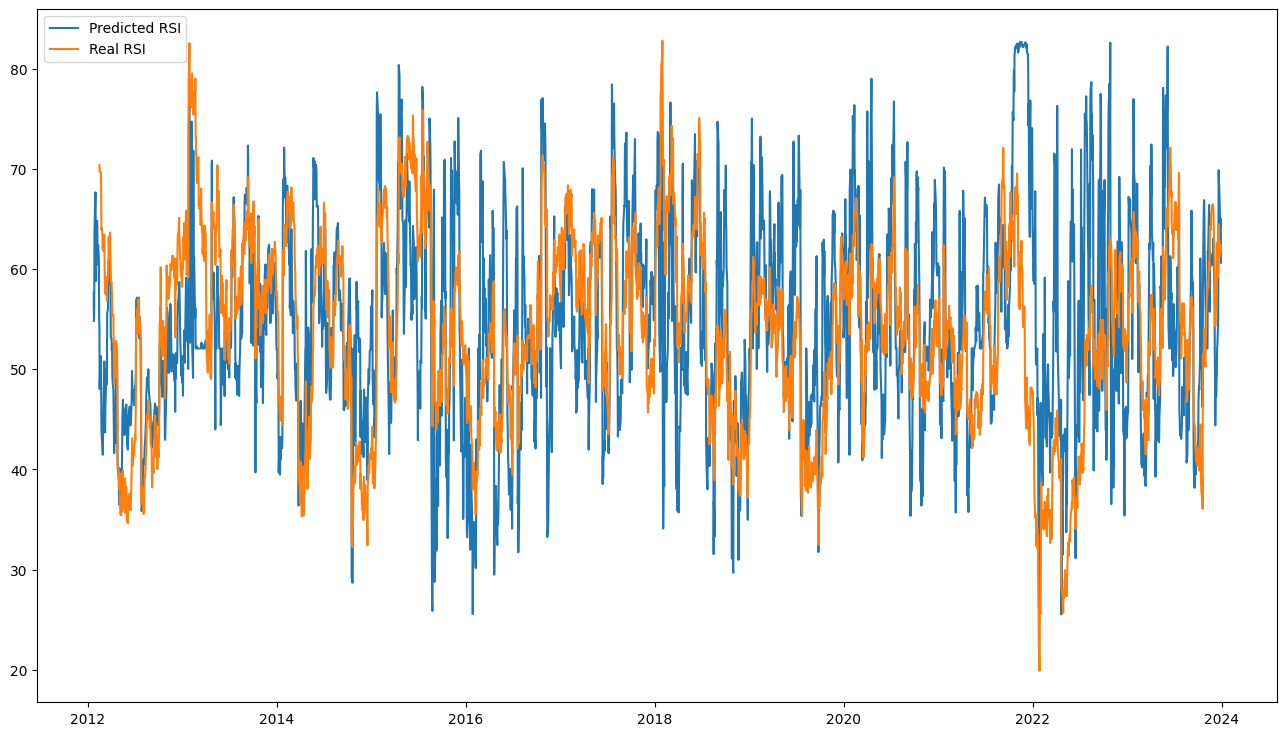

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,9))
plt.plot(dates.astype('datetime64[ns]')[14:],all_predictions,label='Predicted RSI')
plt.plot(dates.astype('datetime64[ns]')[14:],rsi[13:-1],label='Real RSI')
plt.legend()
plt.show()


In [25]:
#predicted_rsi_values

In [46]:
# Calcular las métricas para las predicciones del modelo LSTM
capital_inicial = 100000
costo_inversion = 5000


# Inicializar variables y listas para el análisis de rendimiento
capital_actual = capital_inicial
posiciones = []
rendimientos = []

# Recorrer todas las fechas para realizar las operaciones de compra y venta
for i in range(sequence_length,len(dates) - sequence_length):
    date = dates[i]
    # print(len(dates))
    rsi_value = predicted_rsi_values[i]

    if rsi_value < 40:
        signal = 'Compra'
    elif rsi_value > 70:
        signal = 'Venta'
    else:
        signal = 'Neutral'

    if signal == 'Compra':
        # Calcula la cantidad de acciones que puedes comprar con el costo de inversión fijo
        cantidad_acciones = int(costo_inversion / prices[i])
        # Resta el costo de la inversión del capital disponible
        capital_actual -= costo_inversion
        # Agrega la posición a la lista de posiciones con el precio de compra
        posiciones.append({'Fecha': date, 'Cantidad': cantidad_acciones, 'Precio de compra': prices[i]})

    elif signal == 'Venta':
        for posicion in posiciones:
            cantidad_acciones = posicion['Cantidad']
            precio_compra = posicion['Precio de compra']
            precio_venta = prices[i]
            rentabilidad = (precio_venta - precio_compra) / precio_compra
            rendimientos.append(rentabilidad)

            capital_actual += cantidad_acciones * precio_venta

        posiciones = []

# Calcula el rendimiento acumulado
rendimiento_acumulado = (capital_actual - capital_inicial) / capital_inicial

# Calcula la rentabilidad total considerando todas las operaciones realizadas
rentabilidad_total = np.prod(1 + np.array(rendimientos))

# Imprime la rentabilidad total después de vender todas las acciones compradas
print("Rentabilidad total después de vender todas las acciones compradas:", rentabilidad_total)

# Imprime las métricas adicionales según lo que necesites
print("Métricas:")
print("Rendimiento acumulado:", rendimiento_acumulado)

# Número total de operaciones realizadas (compras y ventas)
num_operaciones = len(rendimientos)
print("Número total de operaciones:", num_operaciones)

# Número de operaciones ganadoras y perdedoras
num_operaciones_ganadoras = len([rendimiento for rendimiento in rendimientos if rendimiento >= 0])
num_operaciones_perdedoras = len([rendimiento for rendimiento in rendimientos if rendimiento < 0])
print("Número de operaciones ganadoras:", num_operaciones_ganadoras)
print("Número de operaciones perdedoras:", num_operaciones_perdedoras)

# Rendimiento promedio de operaciones ganadoras y perdedoras
rendimiento_promedio_ganadoras = np.mean([rendimiento for rendimiento in rendimientos if rendimiento >= 0])
rendimiento_promedio_perdedoras = np.mean([rendimiento for rendimiento in rendimientos if rendimiento < 0])
print("Rendimiento promedio de operaciones ganadoras:", rendimiento_promedio_ganadoras)
print("Rendimiento promedio de operaciones perdedoras:", rendimiento_promedio_perdedoras)

Rentabilidad total después de vender todas las acciones compradas: 3.4420356295655303e-13
Métricas:
Rendimiento acumulado: [-1.2877038]
Número total de operaciones: 187
Número de operaciones ganadoras: 40
Número de operaciones perdedoras: 147
Rendimiento promedio de operaciones ganadoras: 0.1555918206378497
Rendimiento promedio de operaciones perdedoras: -0.19709191250653613


/tmp/ipykernel_24233/165971875.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cantidad_acciones = int(costo_inversion / prices[i])
